# ARIMA Forecasts for Generation and Capacity

This notebook loads `cleaned_generation_data.csv` and `cleaned_capacity_data.csv`, fits ARIMA models to each numeric series, and forecasts the next 5 years (steps) for each series. It produces plots of historical data with forecasted values and saves forecast CSVs.

Notes:
- Uses `pmdarima`'s `auto_arima` to select model orders.
- Assumes `Year` is the annual period and forecasts 5 future years.
- Install dependencies if needed: `pip install pandas matplotlib pmdarima seaborn`

## 1. Setup and imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import warnings

# Try to import pmdarima; if it fails (binary mismatch), fall back to statsmodels' SARIMAX
use_pmdarima = False
try:
    from pmdarima import auto_arima
    use_pmdarima = True
    print('pmdarima imported; will use auto_arima for model selection.')
except Exception as e:
    print('pmdarima not available or failed to import. Falling back to statsmodels.SARIMAX. Error:', e)
    use_pmdarima = False
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)


pmdarima not available or failed to import. Falling back to statsmodels.SARIMAX. Error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


## 2. Load data

In [2]:
gen = pd.read_csv('cleaned_generation_data.csv')
cap = pd.read_csv('cleaned_capacity_data.csv')

# Convert Year to datetime (use start of year)
gen['Year'] = pd.to_datetime(gen['Year'], format='%Y')
cap['Year'] = pd.to_datetime(cap['Year'], format='%Y')

gen = gen.set_index('Year')
cap = cap.set_index('Year')

gen.head(), cap.head()

(            Biogas  Coal and peat  Marine energy  Natural gas   Nuclear  \
 Year                                                                      
 2015-01-01  1534.0        62055.0           13.0      64639.0  101809.0   
 2016-01-01  1427.0        62197.0           19.0      61795.0  101429.0   
 2017-01-01  1451.0        60104.0            6.0      54248.0  101299.0   
 2018-01-01  1408.0        50536.0           20.0      66895.0  100731.0   
 2019-01-01  1378.0        47873.0            1.0      68235.0  101197.0   
 
                Oil  Onshore wind energy  Other non-renewable energy  \
 Year                                                                  
 2015-01-01  7718.0              26964.0                       261.0   
 2016-01-01  7783.0              30930.0                       306.0   
 2017-01-01  5672.0              31511.0                       328.0   
 2018-01-01  5821.0              33468.0                       343.0   
 2019-01-01  5081.0              3

## 3. Quick data checks

In [3]:
print('Generation shape:', gen.shape)
print('Capacity shape:', cap.shape)

print('Missing values in generation:')
print(gen.isna().sum())

print('Missing values in capacity:')
print(cap.isna().sum())


Generation shape: (9, 15)
Capacity shape: (10, 16)
Missing values in generation:
Biogas                        0
Coal and peat                 0
Marine energy                 0
Natural gas                   0
Nuclear                       0
Oil                           0
Onshore wind energy           0
Other non-renewable energy    0
Pumped storage                0
Renewable hydropower          0
Renewable municipal waste     0
Solar photovoltaic            0
Solid biofuels                0
Total non-renewable           0
Total renewable               0
dtype: int64
Missing values in capacity:
Biogas                        0
Coal and peat                 0
Fossil fuels n.e.s.           0
Marine energy                 0
Natural gas                   0
Nuclear                       0
Oil                           0
Onshore wind energy           0
Other non-renewable energy    0
Pumped storage                0
Renewable hydropower          0
Renewable municipal waste     0
Solar photovol

## 4. Forecasting helper functions

In [4]:
def fit_forecast_series(series, n_periods=5, seasonal=False, m=1, trace=False):
    """Fit auto_arima (pmdarima) when available, otherwise fit a simple SARIMAX as fallback, and forecast n_periods ahead.
    Returns a DataFrame with forecast, lower/upper 95% conf int, and the model (or statsmodels result).
    """
    # drop NA
    s = series.dropna().astype(float)
    if len(s) < 3:
        # not enough data to fit ARIMA; repeat last value
        last = s.iloc[-1] if len(s) > 0 else np.nan
        index = pd.date_range(start=series.index[-1] + pd.offsets.DateOffset(years=1), periods=n_periods, freq='YS')
        return pd.DataFrame({'forecast':[last]*n_periods}, index=index), None

    # Use pmdarima auto_arima if available
    if use_pmdarima:
        try:
            model = auto_arima(s, seasonal=seasonal, m=m, suppress_warnings=True, trace=trace, error_action='ignore')
            fc, conf_int = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)
            index = pd.date_range(start=series.index[-1] + pd.offsets.DateOffset(years=1), periods=n_periods, freq='YS')
            df = pd.DataFrame({'forecast': fc, 'lower': conf_int[:,0], 'upper': conf_int[:,1]}, index=index)
            return df, model
        except Exception as e:
            print('pmdarima fit failed for series:', series.name, 'error:', e)
            # fall through to statsmodels fallback

    # Fallback: fit a simple SARIMAX(1,1,1)
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model_sm = SARIMAX(s, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
        res = model_sm.fit(disp=False)
        pred = res.get_forecast(steps=n_periods)
        fc = pred.predicted_mean.values
        conf_int = pred.conf_int(alpha=0.05).values
        index = pd.date_range(start=series.index[-1] + pd.offsets.DateOffset(years=1), periods=n_periods, freq='YS')
        df = pd.DataFrame({'forecast': fc, 'lower': conf_int[:,0], 'upper': conf_int[:,1]}, index=index)
        return df, res
    except Exception as e:
        print('Fallback SARIMAX failed for series:', series.name, 'error:', e)
        last = s.iloc[-1] if len(s) > 0 else np.nan
        index = pd.date_range(start=series.index[-1] + pd.offsets.DateOffset(years=1), periods=n_periods, freq='YS')
        return pd.DataFrame({'forecast':[last]*n_periods}, index=index), None


## 5. Forecast all series (Generation)

In [5]:
gen_forecasts = {}
gen_models = {}
for col in gen.columns:
    print('Fitting', col)
    df_fc, model = fit_forecast_series(gen[col], n_periods=5, seasonal=False, m=1)
    gen_forecasts[col] = df_fc
    gen_models[col] = model

# Combine forecasts into a single DataFrame
gen_fc_df = pd.concat({k: v['forecast'] for k, v in gen_forecasts.items()}, axis=1)
gen_fc_df.index.name = 'Year'
gen_fc_df.to_csv('generation_forecasts.csv')
gen_fc_df.head()

Fitting Biogas
Fitting Coal and peat
Fitting Marine energy
Fitting Coal and peat
Fitting Marine energy
Fitting Natural gas
Fitting Nuclear
Fitting Oil
Fitting Natural gas
Fitting Nuclear
Fitting Oil
Fitting Onshore wind energy
Fitting Other non-renewable energy
Fitting Onshore wind energy
Fitting Other non-renewable energy
Fitting Pumped storage
Fitting Renewable hydropower
Fitting Renewable municipal waste
Fitting Pumped storage
Fitting Renewable hydropower
Fitting Renewable municipal waste
Fitting Solar photovoltaic
Fitting Solid biofuels
Fitting Solar photovoltaic
Fitting Solid biofuels
Fitting Total non-renewable
Fitting Total non-renewable
Fitting Total renewable
Fitting Total renewable


,Biogas,Coal and peat,Marine energy,Natural gas,Nuclear,Oil,Onshore wind energy,Other non-renewable energy,Pumped storage,Renewable hydropower,Renewable municipal waste,Solar photovoltaic,Solid biofuels,Total non-renewable,Total renewable
Year,,,,,,,,,,,,,,,
2024-01-01,1917.158252,21246.890388,1.000003,102262.582482,90535.812295,5178.377598,41242.938192,465.954706,111.0,418870.256175,171.556017,8701.636034,8472.947524,214180.621164,464727.263342
2025-01-01,1922.714872,19580.876897,1.000001,107730.485135,91152.017300,4682.500428,41774.447976,458.666577,111.0,327897.107310,172.806697,10897.605200,8473.843607,214183.952496,403313.757750
2026-01-01,1918.201986,18374.675795,1.000002,112743.907773,91407.058590,5179.881719,42157.794440,453.857578,111.0,470168.640685,171.723443,13854.905590,8473.924326,214184.711517,485501.533423
2027-01-01,1921.867189,17501.380887,1.000001,117340.625772,91512.617713,4680.991745,42434.279494,450.684407,111.0,247672.338627,172.661684,17837.486825,8473.931598,214184.884455,375512.201191
2028-01-01,1918.890444,16869.111528,1.000002,121555.274704,91556.307612,5181.394978,42633.691755,448.590622,111.0,595630.944648,171.849043,23200.808505,8473.932253,214184.923858,522707.487908


## 6. Forecast all series (Capacity)

In [6]:
cap_forecasts = {}
cap_models = {}
for col in cap.columns:
    print('Fitting', col)
    df_fc, model = fit_forecast_series(cap[col], n_periods=5, seasonal=False, m=1)
    cap_forecasts[col] = df_fc
    cap_models[col] = model

cap_fc_df = pd.concat({k: v['forecast'] for k, v in cap_forecasts.items()}, axis=1)
cap_fc_df.index.name = 'Year'
cap_fc_df.to_csv('capacity_forecasts.csv')
cap_fc_df.head()

Fitting Biogas
Fitting Coal and peat
Fitting Fossil fuels n.e.s.
Fitting Coal and peat
Fitting Fossil fuels n.e.s.
FittingFitting Marine energy
Fitting Natural gas
 Marine energy
Fitting Natural gas
Fitting Nuclear
Fitting Nuclear
Fitting Oil
Fitting Onshore wind energy
Fitting Oil
Fitting Onshore wind energy
Fitting Other non-renewable energy
Fitting Pumped storage
Fitting Other non-renewable energy
Fitting Pumped storage
Fitting Renewable hydropower
Fitting Renewable hydropower
Fitting Renewable municipal waste
Fitting Solar photovoltaic
Fitting Solid biofuels
Fitting Renewable municipal waste
Fitting Solar photovoltaic
Fitting Solid biofuels
Fitting Total non-renewable
Fitting Total renewable
Fitting Total non-renewable
Fitting Total renewable


,Biogas,Coal and peat,Fossil fuels n.e.s.,Marine energy,Natural gas,Nuclear,Oil,Onshore wind energy,Other non-renewable energy,Pumped storage,Renewable hydropower,Renewable municipal waste,Solar photovoltaic,Solid biofuels,Total non-renewable,Total renewable
Year,,,,,,,,,,,,,,,,
2025-01-01,358.473107,2971.792794,1374.264279,1.2,20219.786401,12748.440675,6019.622982,18973.335683,38.005941,174.0,83512.469143,38.005941,6609.203107,2316.899852,45220.735341,111104.969488
2026-01-01,364.097738,2398.747279,1374.438342,1.2,19803.711404,12688.325719,6019.246911,20646.042181,38.005676,174.0,83518.884843,38.005676,7584.644229,2316.791848,45232.899582,112517.169472
2027-01-01,368.985109,1956.308620,1374.552987,1.2,19641.038794,12733.816369,6019.473931,22576.412090,38.005688,174.0,83521.729601,38.005688,8723.052755,2316.781245,45230.013213,113763.246833
2028-01-01,373.231857,1614.709284,1374.628496,1.2,19577.438775,12699.392335,6019.336887,24804.135836,38.005687,174.0,83522.990982,38.005687,10051.655725,2316.780204,45230.698100,114862.743225
2029-01-01,376.921954,1350.966268,1374.678228,1.2,19552.573111,12725.441954,6019.419615,27375.017752,38.005687,174.0,83523.550286,38.005687,11602.229013,2316.780102,45230.535587,115832.901545


## 7. Plot examples

Below we plot a few example series with forecasts.

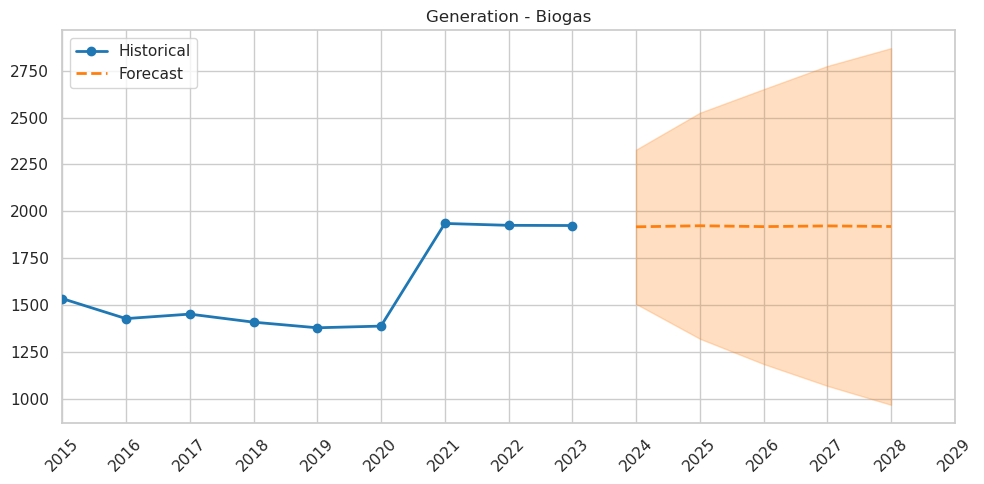

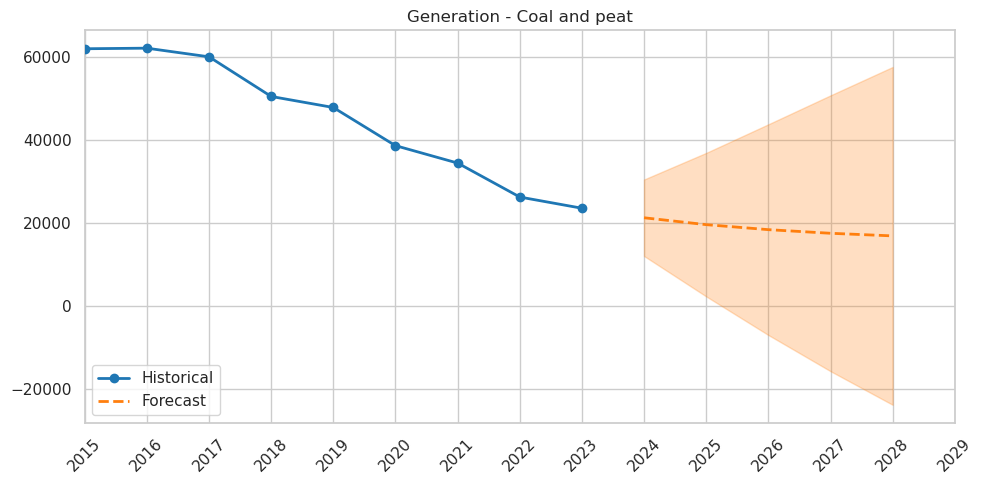

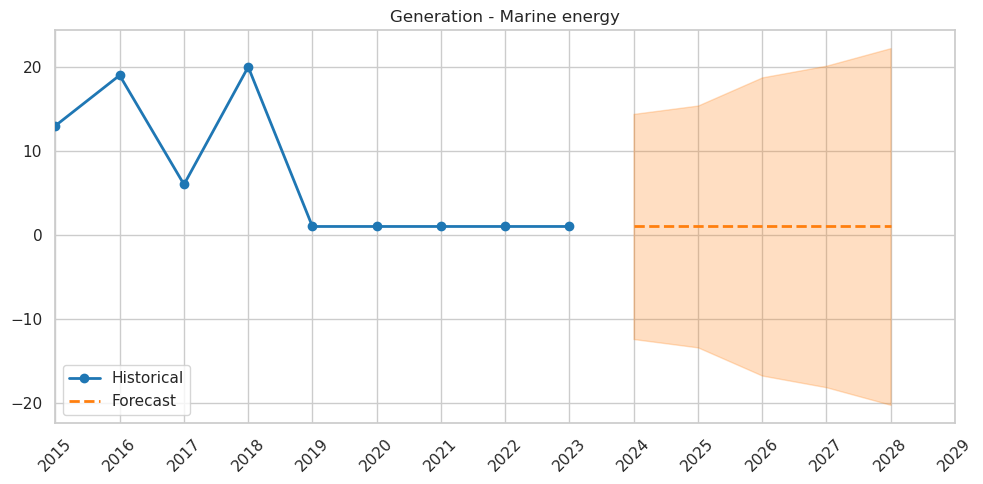

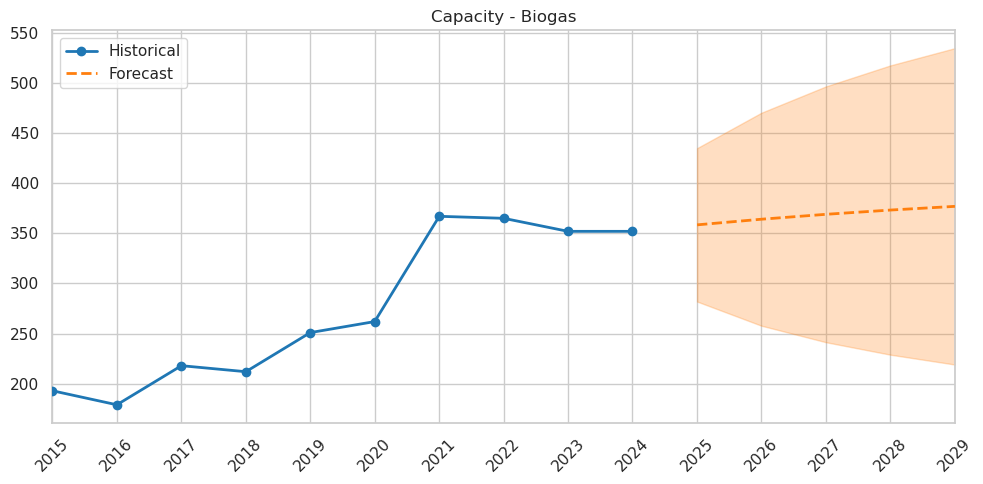

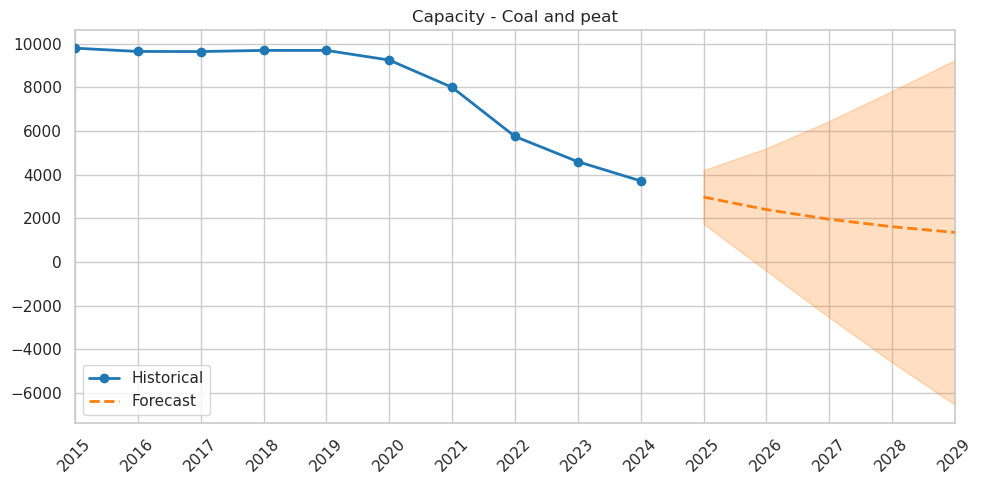

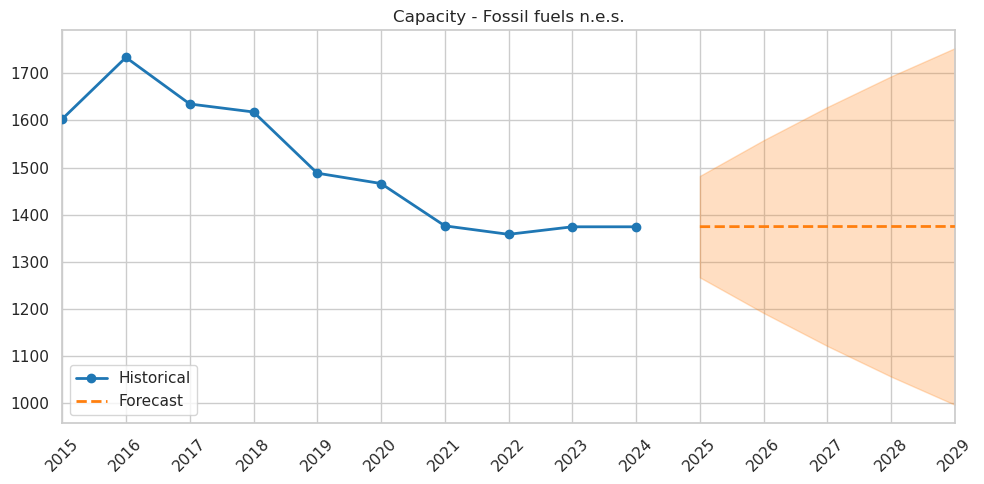

In [7]:
def plot_series_with_fc(series, fc_df, title=None, hist_color='#1f77b4', fc_color='#ff7f0e'):
    plt.figure()
    ax = plt.gca()

    # Ensure historical index is datetime and plot with markers so it is visible
    hist_index = pd.to_datetime(series.index)
    ax.plot(hist_index, series.values, label='Historical', color=hist_color, linewidth=2, marker='o', markersize=6, zorder=4)

    if fc_df is not None and not fc_df.empty:
        # convert index years to datetime if needed
        fc_index = pd.to_datetime(fc_df.index)
        ax.plot(fc_index, fc_df['forecast'].values, label='Forecast', color=fc_color, linewidth=2, linestyle='--', zorder=3)
        if 'lower' in fc_df.columns and 'upper' in fc_df.columns:
            ax.fill_between(fc_index, fc_df['lower'], fc_df['upper'], color=fc_color, alpha=0.25, zorder=2)

    # set x-axis range from 2015 to 2029
    start = pd.to_datetime('2015')
    end = pd.to_datetime('2029')
    ax.set_xlim(start, end)

    # format x-axis to show yearly ticks
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.title(title or series.name)
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot a few columns
sample_cols = list(gen.columns[:3])
for c in sample_cols:
    plot_series_with_fc(gen[c], gen_forecasts[c], title=f'Generation - {c}')

sample_cols = list(cap.columns[:3])
for c in sample_cols:
    plot_series_with_fc(cap[c], cap_forecasts[c], title=f'Capacity - {c}')


## 8. Save models (optional)

We can save fitted pmdarima models using `joblib` if desired. Uncomment and run if you want to persist models.

In [8]:
# import joblib
# os.makedirs('models', exist_ok=True)
# for k, m in gen_models.items():
#     if m is not None:
#         joblib.dump(m, os.path.join('models', f'gen_{k}.pkl'))
# for k, m in cap_models.items():
#     if m is not None:
#         joblib.dump(m, os.path.join('models', f'cap_{k}.pkl'))

## 9. Notes and next steps

- This notebook uses automatic ARIMA selection; review models for series with structural breaks or low sample size.
- Consider using exogenous variables or seasonal models if you have monthly/quarterly data.
- For reproducibility, pin `pmdarima` version (e.g., 2.2.0) in a `requirements.txt`.